# Californian housing example

In [1]:
import os
import sys

abspath = os.path.abspath("")
sys.path.insert(0, os.path.join(abspath, "..", ".."))

import yaml
import itertools as itt

import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets

from infovar import DiscreteHandler, ContinuousHandler
from infovar.stats.ranking import prob_higher

In [2]:
dataset = datasets.fetch_california_housing()

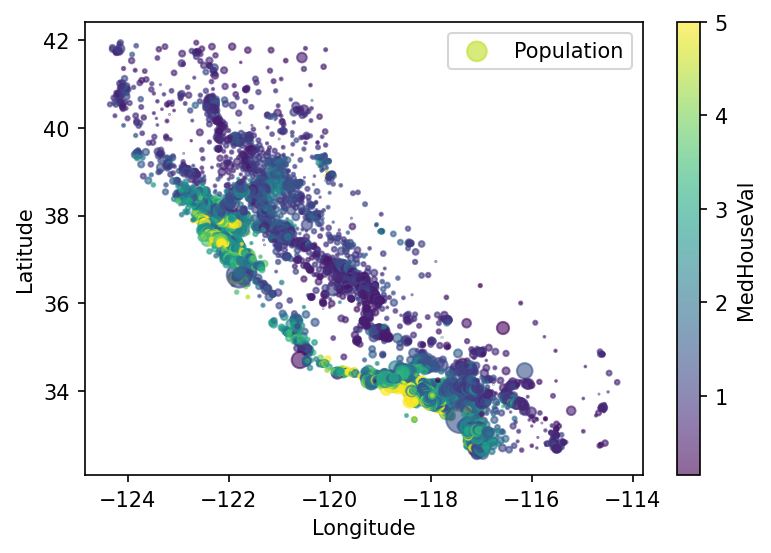

In [3]:
plt.figure(dpi=150)

housing = datasets.fetch_california_housing(as_frame=True).frame
housing.plot(kind="scatter", x="Longitude",y="Latitude", c="MedHouseVal", colorbar=True, legend=True, ax=plt.gca(), s=housing['Population']/200, label="Population", alpha=0.6)

plt.show()

In [4]:
# Filter data > 5 that saturate
filt = dataset.target < 5

In [5]:
_variables = np.concatenate(
    [
        dataset.data[filt],
        np.random.normal(0, 1, size=(filt.sum(), 1)),
    ], axis=1
)
_targets = dataset.target[filt].reshape(-1, 1)

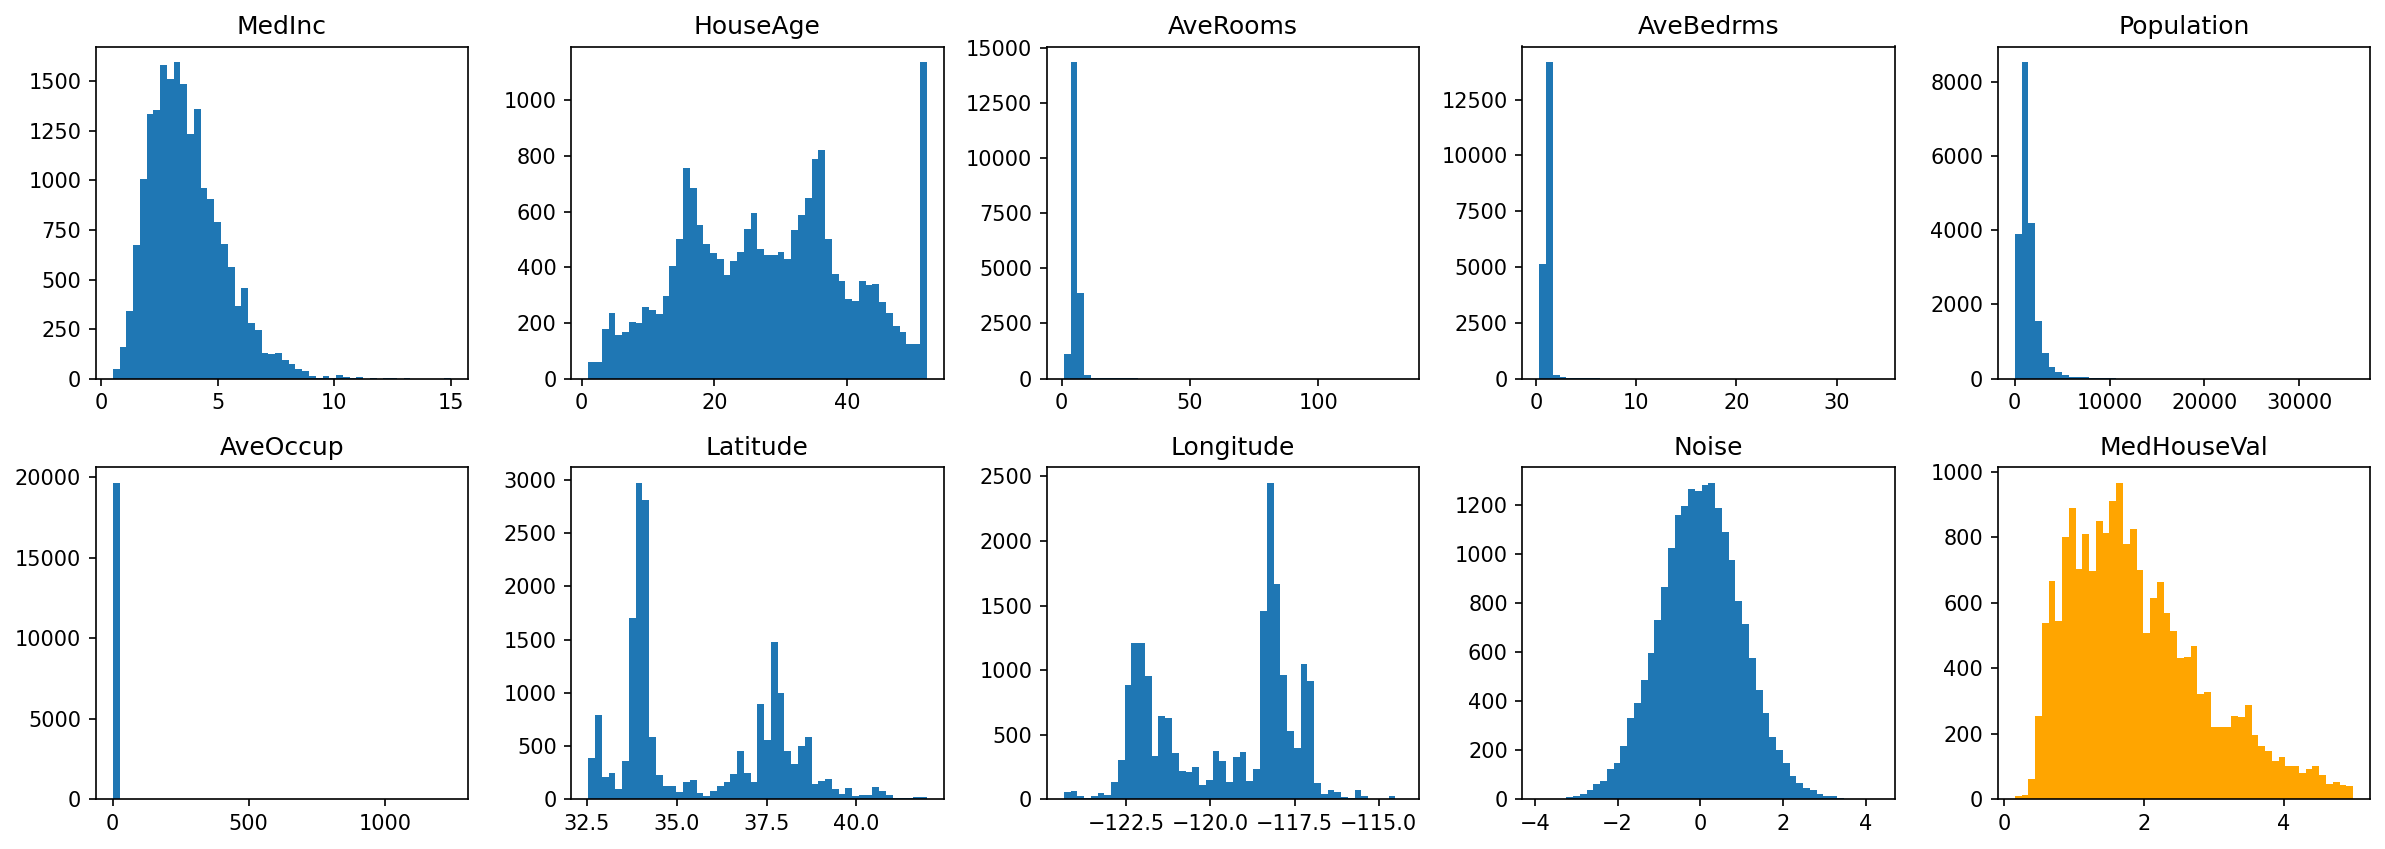

In [6]:
rows, cols = 2, 5
fig, axs = plt.subplots(rows, cols, figsize=(2.5*6.4, 1.2*4.8), dpi=150)
axs = axs.flatten()

for i, name in enumerate(dataset.feature_names + ["Noise"]):
    axs[i].hist(_variables[:, i], bins=50)
    axs[i].set_title(f"{name}")

axs[-1].hist(_targets[:, 0], bins=50, color="orange")
axs[-1].set_title(f"{dataset.target_names[0]}")

plt.tight_layout()
plt.show()

### Preprocessing

Preprocessing is not mandatory in this kind of analysis. Theoretically, the mutual information between variables $X$ and $Y$ is the same as that between $f(X)$ and $g(Y)$, for any bijections $f$ and $g$.

However, the non-parametric estimator may be sensitive to data spanning several orders of magnitude, for example. Ideally, we should try to reduce to data on a single order of magnitude, for example by applying a log, or another less sensitive operation such as $\mathrm{arcsinh}$.

In [7]:
_variables[:, 4] = np.log10(_variables[:, 4]) # Population
_variables[:, 5] = np.log10(_variables[:, 5]) # AveOccup

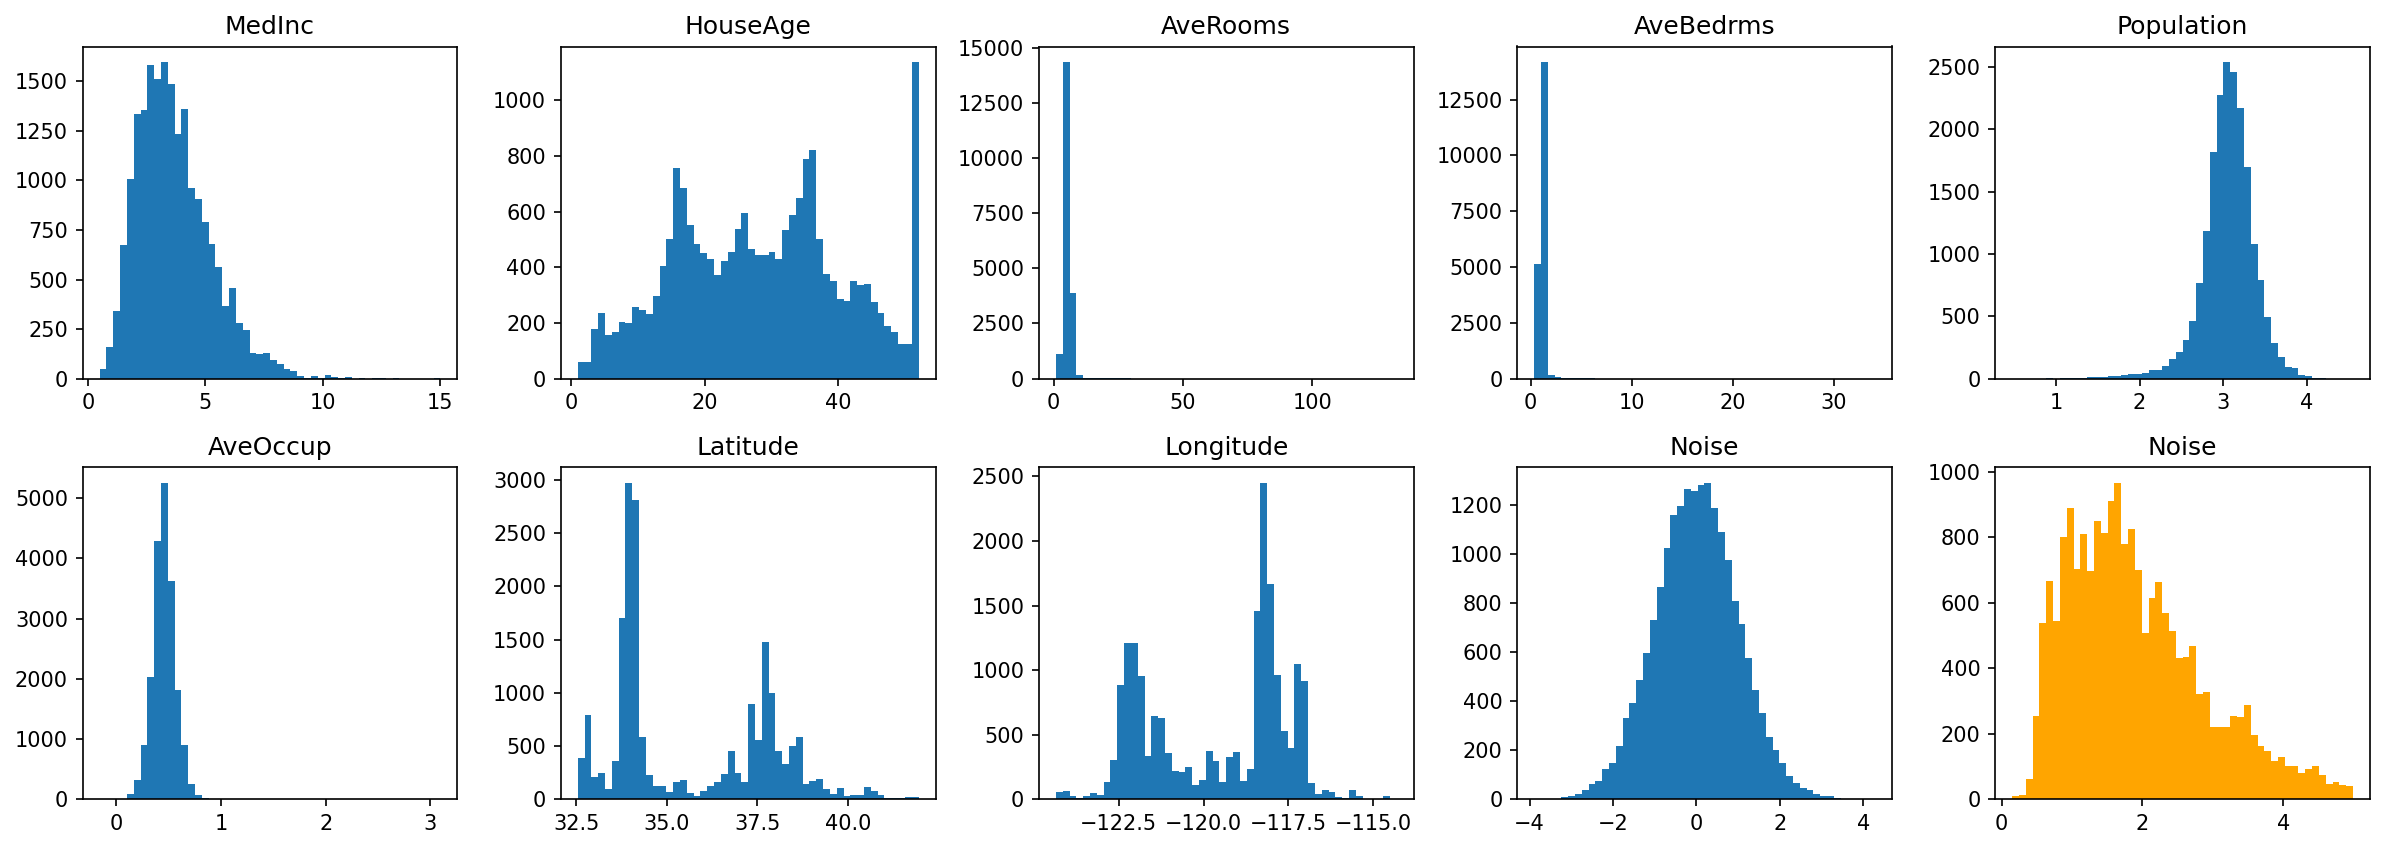

In [8]:
rows, cols = 2, 5
fig, axs = plt.subplots(rows, cols, figsize=(2.5*6.4, 1.2*4.8), dpi=150)
axs = axs.flatten()

for i, name in enumerate(dataset.feature_names + ["Noise"]):
    axs[i].hist(_variables[:, i], bins=50)
    axs[i].set_title(f"{name}")

axs[-1].hist(_targets[:, 0], bins=50, color="orange")
axs[-1].set_title(f"{name}")

plt.tight_layout()
plt.show()

### Handler

In [9]:
save_path = os.path.join(abspath, "data-out")
ref_path = os.path.join(abspath, "reference.yaml")

handler = DiscreteHandler()

handler.set_paths(
    save_path=save_path, ref_path=ref_path
)

handler.set_data(
    variables=_variables,
    variable_names=dataset.feature_names + ["Noise"],
    targets=_targets,
    target_names=dataset.target_names,
)

### Data analysis

In [10]:
handler.overview()

Variables:
	MedInc: [0.50, 15.00]
	HouseAge: [1.00, 52.00]
	AveRooms: [0.85, 132.53]
	AveBedrms: [0.33, 34.07]
	Population: [0.48, 4.55]
	AveOccup: [-0.16, 3.09]
	Latitude: [32.54, 41.95]
	Longitude: [-124.35, -114.31]
	Noise: [-3.89, 4.28]

Targets:
	MedHouseVal: [0.15, 4.99]

Number of samples: 19,648


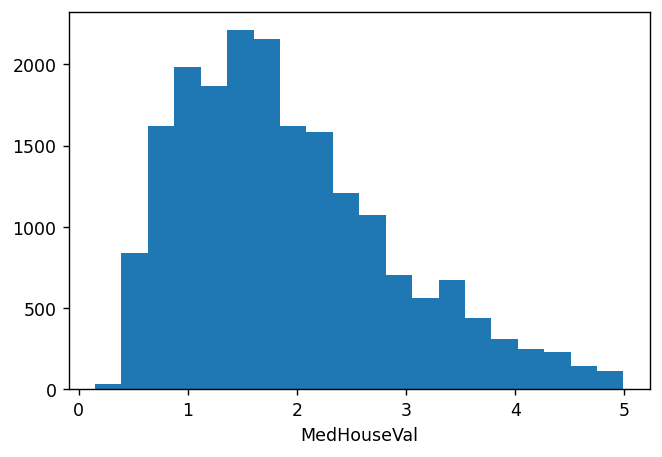

In [11]:
plt.figure(dpi=125)

plt.hist(dataset.target[filt], bins=20)
plt.xlabel(dataset.target_names[0])

plt.show()

## Informativity of each variable

__Note:__ This part will take less than 1 min.

### Statistics computation

In [12]:
with open(os.path.join(abspath, 'inputs-1.yaml'), 'r') as f:
    inputs_dict = yaml.safe_load(f)

In [13]:
handler.update(
    inputs_dict
)

[MedHouseVal]: 100%|██████████| 9/9 [00:00<00:00, 85.37it/s, vars=[Noise]]


### Results analysis

In [14]:
targs = ["MedHouseVal"]

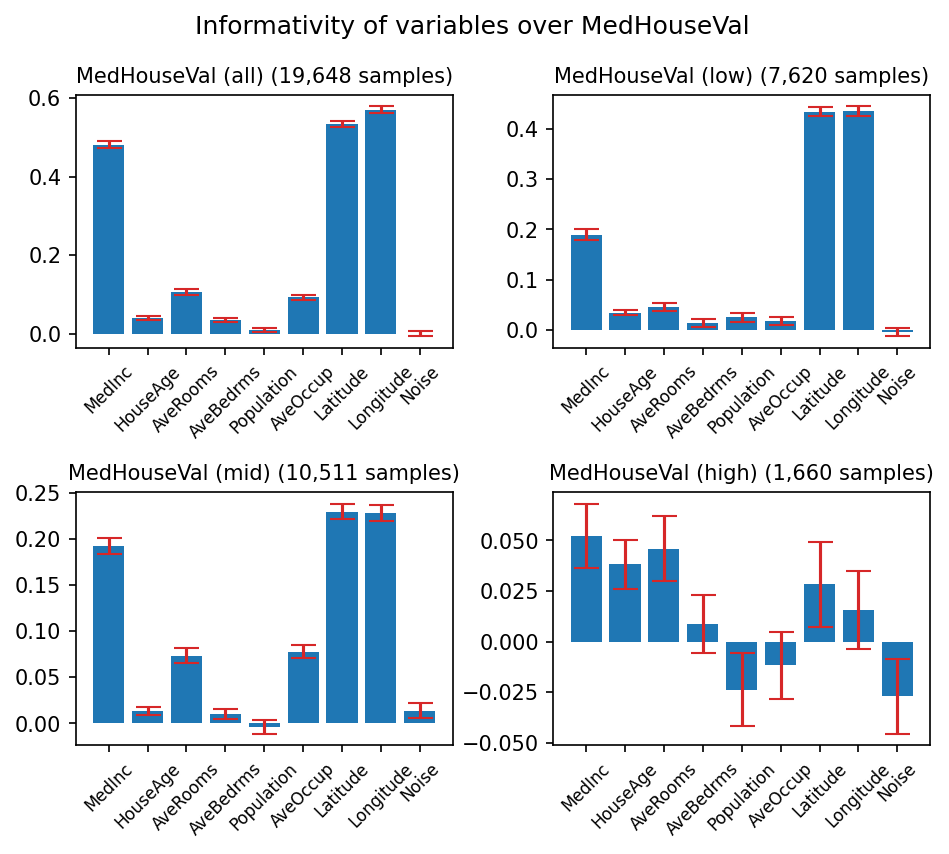

In [15]:
plt.figure(figsize=(1*6.4, 1.2*4.8), dpi=150)

plt.suptitle("Informativity of variables over MedHouseVal")

for i, rgs in enumerate([{"MedHouseVal": "all"}, {"MedHouseVal": "low"}, {"MedHouseVal": "mid"}, {"MedHouseVal": "high"}], 1):

    entries = [
        handler.read(targs, v, rgs) for v in handler.variable_names
    ]

    mis = [el["mi"]["value"] for el in entries]
    stds = [el["mi"]["std"] for el in entries]
    samples = entries[0]["samples"]

    #

    name = list(rgs.values())[0]
    xticks = list(range(len(entries)))

    plt.subplot(2, 2, i)

    plt.bar(xticks, mis)
    plt.errorbar(xticks, mis, yerr=stds, fmt='none', capsize=6, color='tab:red')
    plt.xticks(xticks, labels=handler.variable_names, rotation=45, fontsize=8)

    plt.title(f"MedHouseVal ({name}) ({samples:,} samples)", fontsize=10)

plt.tight_layout()
plt.show()

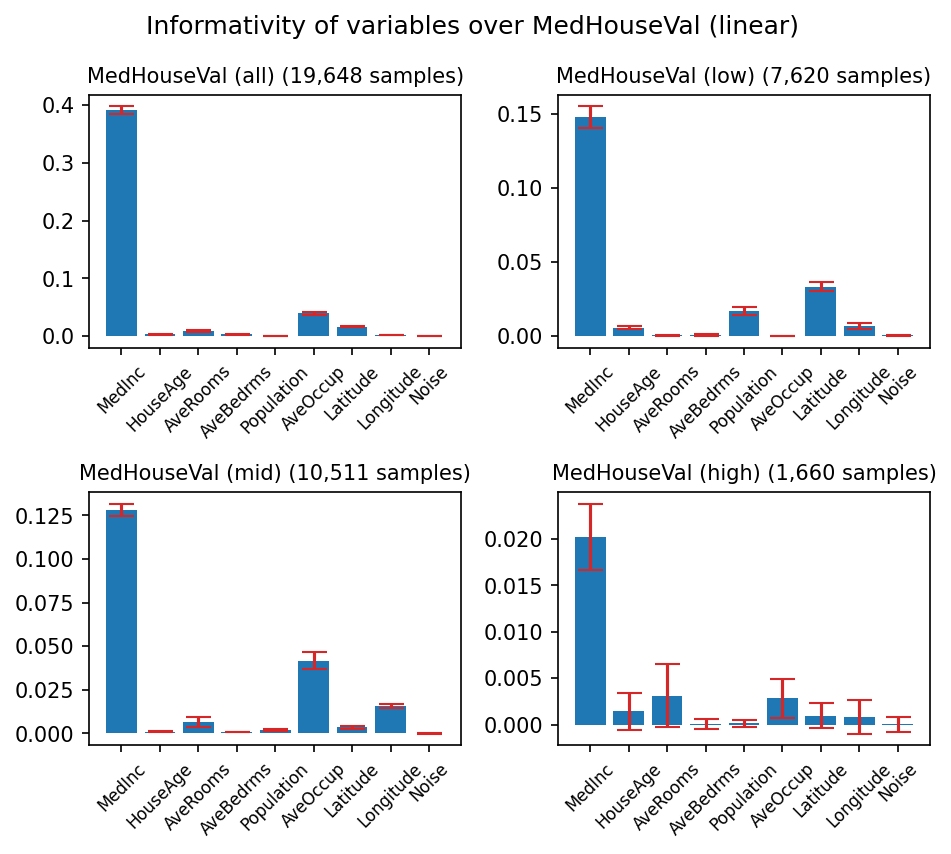

In [16]:
plt.figure(figsize=(1*6.4, 1.2*4.8), dpi=150)

plt.suptitle("Informativity of variables over MedHouseVal (linear)")

for i, rgs in enumerate([{"MedHouseVal": "all"}, {"MedHouseVal": "low"}, {"MedHouseVal": "mid"}, {"MedHouseVal": "high"}], 1):

    entries = [
        handler.read(targs, v, rgs) for v in handler.variable_names
    ]

    lininfo = [el["linearinfo"]["value"] for el in entries]
    stds = [el["linearinfo"]["std"] for el in entries]
    samples = entries[0]["samples"]

    #

    name = list(rgs.values())[0]
    xticks = list(range(len(entries)))

    plt.subplot(2, 2, i)

    plt.bar(xticks, lininfo)
    plt.errorbar(xticks, lininfo, yerr=stds, fmt='none', capsize=6, color='tab:red')
    plt.xticks(xticks, labels=handler.variable_names, rotation=45, fontsize=8)

    plt.title(f"MedHouseVal ({name}) ({samples:,} samples)", fontsize=10)

plt.tight_layout()
plt.show()

### Identification of most informative variable(s)

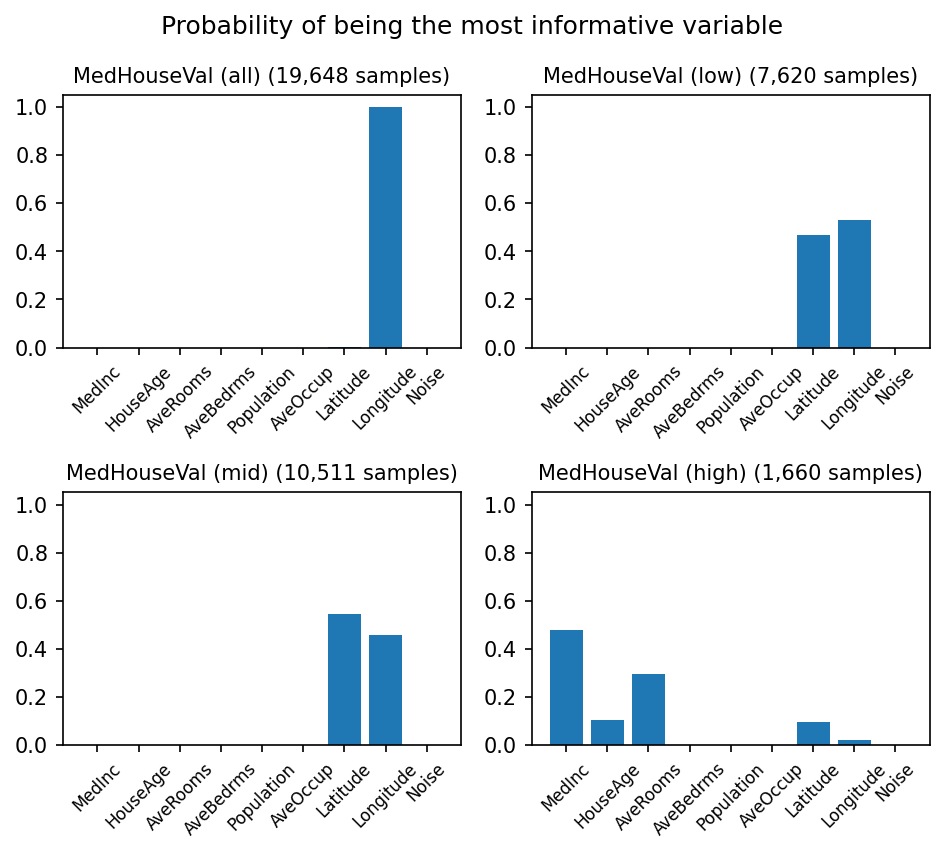

In [17]:
plt.figure(figsize=(1*6.4, 1.2*4.8), dpi=150)

plt.suptitle("Probability of being the most informative variable")

for i, rgs in enumerate([{"MedHouseVal": "all"}, {"MedHouseVal": "low"}, {"MedHouseVal": "mid"}, {"MedHouseVal": "high"}], 1):

    entries = [
        handler.read(targs, v, rgs) for v in handler.variable_names
    ]

    mis = [el["mi"]["value"] for el in entries]
    stds = [el["mi"]["std"] for el in entries]
    samples = entries[0]["samples"]

    #

    probs = prob_higher(mis, stds, approx=False)

    #

    name = list(rgs.values())[0]
    xticks = list(range(len(entries)))

    plt.subplot(2, 2, i)

    plt.bar(xticks, probs)
    plt.xticks(xticks, labels=handler.variable_names, rotation=45, fontsize=8)
    plt.ylim([0, 1.05])

    plt.title(f"MedHouseVal ({name}) ({samples:,} samples)", fontsize=10)

plt.tight_layout()
plt.show()

### Interpretation: latitude and longitude

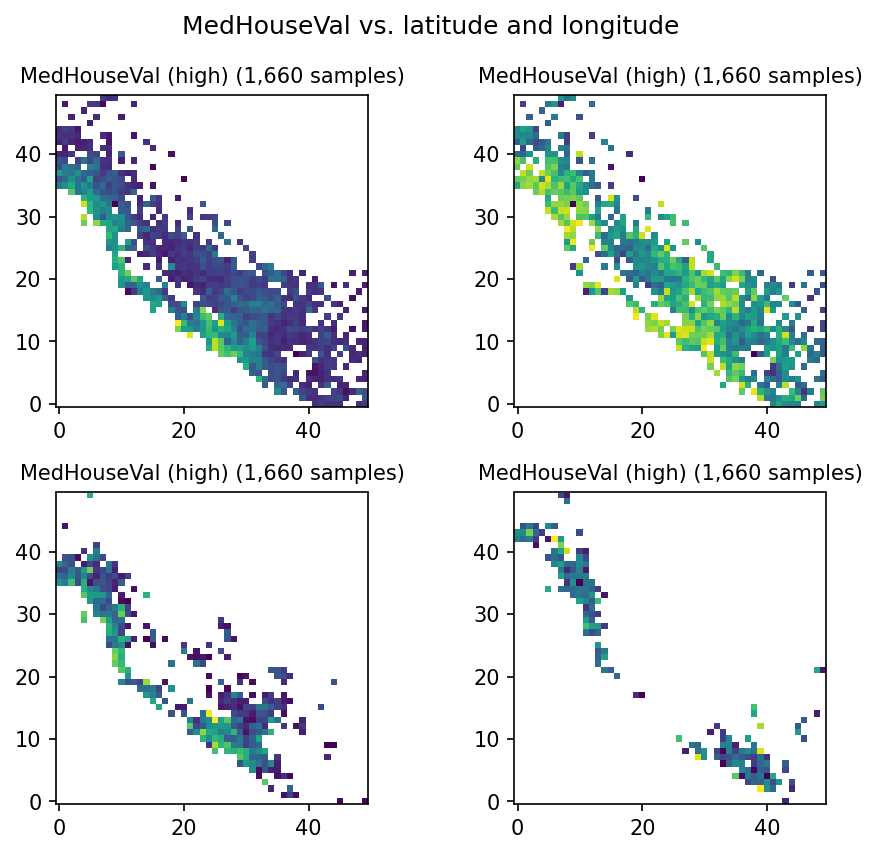

In [18]:
from scipy.stats import binned_statistic_2d

plt.figure(figsize=(1*6.4, 1.2*4.8), dpi=150)

plt.suptitle("MedHouseVal vs. latitude and longitude")

temp = {
    "all": None,
    "low": [None, 1.5],
    "mid": [1.5, 3.5],
    "high": [3.5, None]
}

for i, rgs in enumerate([{"MedHouseVal": "all"}, {"MedHouseVal": "low"}, {"MedHouseVal": "mid"}, {"MedHouseVal": "high"}], 1):

    vars, targs = handler._filter_data(
        vars= ["Latitude", "Longitude"],
        targs="MedHouseVal",
        ranges={key: temp[name] for key, name in rgs.items()}
    )

    #

    ret = binned_statistic_2d(vars[:, 0], vars[:, 1], targs[:, 0], statistic=np.mean, bins=(50, 50))

    plt.subplot(2, 2, i)

    plt.imshow(ret.statistic.T, origin="lower")

    plt.title(f"MedHouseVal ({name}) ({samples:,} samples)", fontsize=10)

plt.tight_layout()
plt.show()


When you consider all the data, geographical position is essential. The figure above shows that most expensive homes are located in very specific areas.

When only expensive homes are considered, however, geographical location is no longer a determining factor. There doesn't seem to be any variable that is much more informative than the others.

## Informativity of a couple of two variables

__Note:__ This part will take a few minutes.

### Statistics computation

In [19]:
with open(os.path.join(abspath, 'inputs-2.yaml'), 'r') as f:
    inputs_dict = yaml.safe_load(f)

In [20]:
handler.update(
    inputs_dict
)

[MedHouseVal]: 100%|██████████| 36/36 [00:00<00:00, 74.05it/s, vars=[Longitude, Noise]]     


### Results analysis

In [21]:
targs = ["MedHouseVal"]

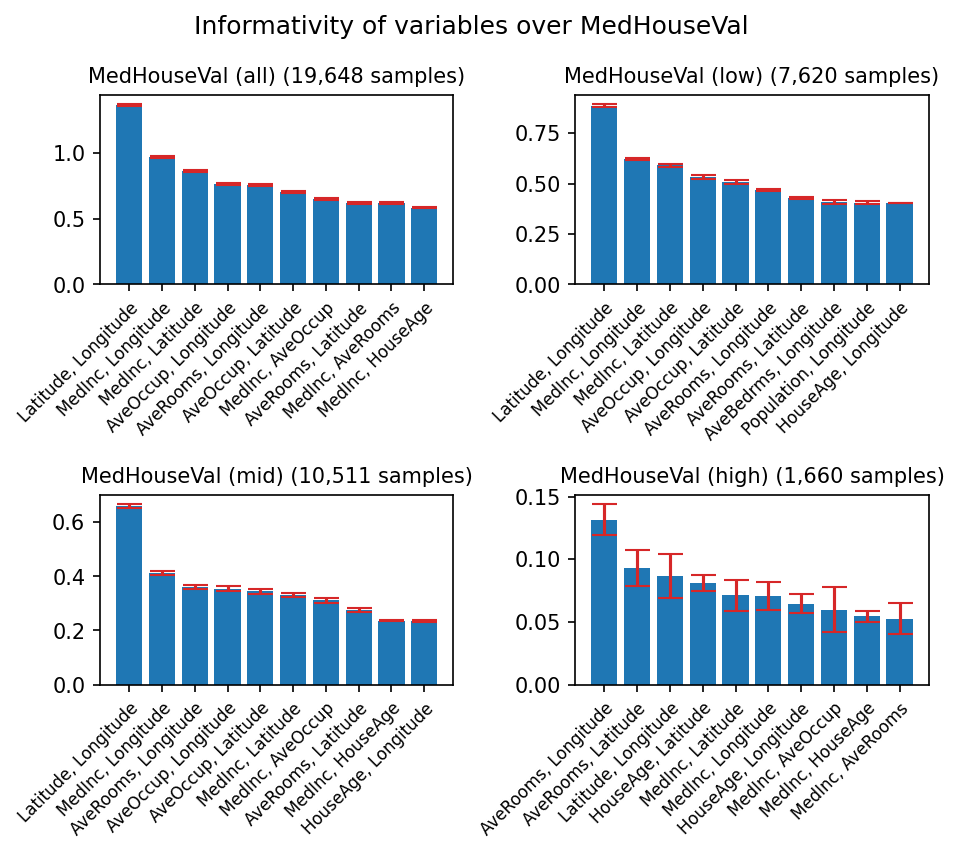

In [22]:
plt.figure(figsize=(1*6.4, 1.2*4.8), dpi=150)

plt.suptitle("Informativity of variables over MedHouseVal")

for i, rgs in enumerate([{"MedHouseVal": "all"}, {"MedHouseVal": "low"}, {"MedHouseVal": "mid"}, {"MedHouseVal": "high"}], 1):

    comb_list = list(itt.combinations(handler.variable_names, 2))

    entries = [
        handler.read(targs, c, rgs) for c in comb_list
    ]

    mis = [el["mi"]["value"] for el in entries]
    stds = [el["mi"]["std"] for el in entries]
    samples = entries[0]["samples"]

    # We keep the 10 most informative combinations of variables
    order = np.argsort(mis)[::-1][:10]
    _mis = [mis[i] for i in order]
    _stds = [stds[i] for i in order]
    _comb_list = [comb_list[i] for i in order]

    #

    name = list(rgs.values())[0]
    xticks = list(range(len(_mis)))

    plt.subplot(2, 2, i)

    plt.bar(xticks, _mis)
    plt.errorbar(xticks, _mis, yerr=_stds, fmt='none', capsize=6, color='tab:red')
    plt.xticks(xticks, labels=[", ".join(c) for c in _comb_list], rotation=45, fontsize=8, ha='right', rotation_mode='anchor')

    plt.title(f"MedHouseVal ({name}) ({samples:,} samples)", fontsize=10)

plt.tight_layout()
plt.show()

In [23]:
for i, rgs in enumerate([{"MedHouseVal": "all"}, {"MedHouseVal": "low"}, {"MedHouseVal": "mid"}, {"MedHouseVal": "high"}], 1):

    comb_list = list(itt.combinations(handler.variable_names, 2))

    entries = [
        handler.read(targs, [v1, v2], rgs) for (v1, v2) in comb_list
    ]

    mis = [el["mi"]["value"] for el in entries]
    stds = [el["mi"]["std"] for el in entries]
    samples = entries[0]["samples"]

    probs = prob_higher(mis, stds)
    nz = np.count_nonzero(probs)

    order = np.argsort(probs)[::-1][:nz]
    _probs = [probs[i] for i in order]
    _comb_list = [comb_list[i] for i in order]

    name = list(rgs.values())[0]

    print(f"Range: {name}")
    for i, (p, c) in enumerate(zip(_probs, _comb_list), 1):
        print(f"{i}. {', '.join(c)}: {100*p:.1f}%")
    print()

Range: all
1. Latitude, Longitude: 100.0%

Range: low
1. Latitude, Longitude: 100.0%

Range: mid
1. Latitude, Longitude: 100.0%

Range: high
1. AveRooms, Longitude: 96.4%
2. AveRooms, Latitude: 1.8%



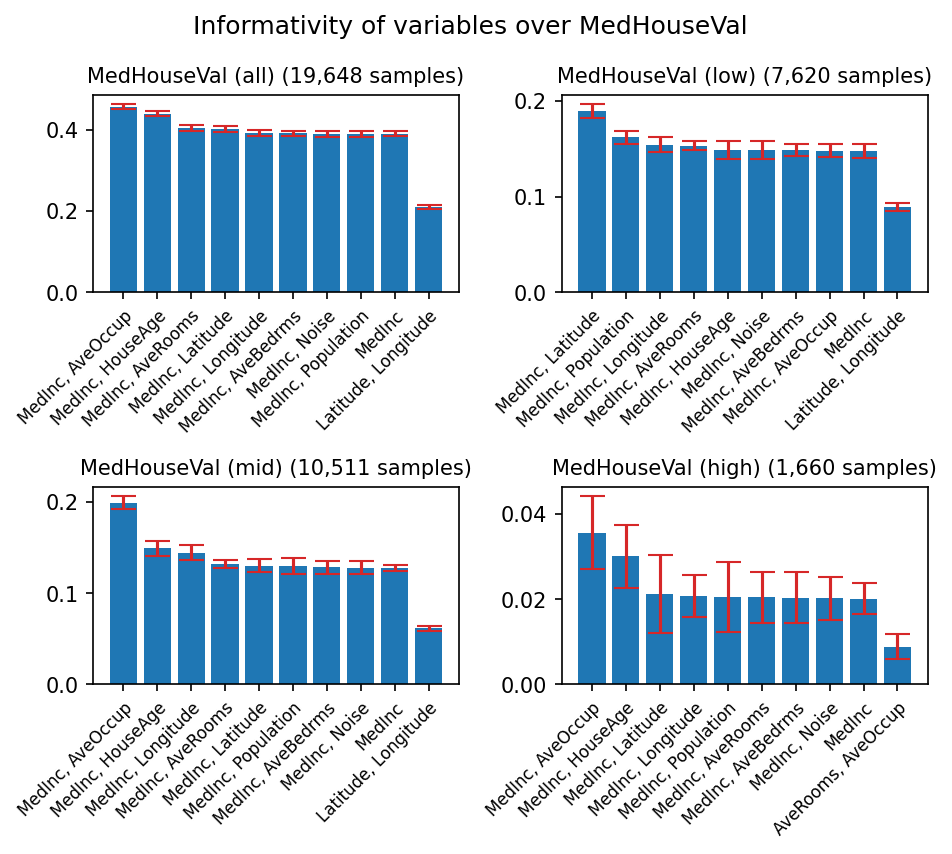

In [24]:
plt.figure(figsize=(1*6.4, 1.2*4.8), dpi=150)

plt.suptitle("Informativity of variables over MedHouseVal")

for i, rgs in enumerate([{"MedHouseVal": "all"}, {"MedHouseVal": "low"}, {"MedHouseVal": "mid"}, {"MedHouseVal": "high"}], 1):

    comb_list = list(itt.combinations_with_replacement(handler.variable_names, 2))
    for k, (v1, v2) in enumerate(comb_list):
        comb_list[k] = [v1] if v1 == v2 else [v1, v2]

    entries = [
        handler.read(targs, c, rgs) for c in comb_list
    ]

    mis = [el["linearinfo"]["value"] for el in entries]
    stds = [el["linearinfo"]["std"] for el in entries]
    samples = entries[0]["samples"]

    # We keep the 10 most informative combinations of variables
    order = np.argsort(mis)[::-1][:10]
    _mis = [mis[i] for i in order]
    _stds = [stds[i] for i in order]
    _comb_list = [comb_list[i] for i in order]

    #

    name = list(rgs.values())[0]
    xticks = list(range(len(_mis)))

    plt.subplot(2, 2, i)

    plt.bar(xticks, _mis)
    plt.errorbar(xticks, _mis, yerr=_stds, fmt='none', capsize=6, color='tab:red')
    plt.xticks(xticks, labels=[", ".join(c) for c in _comb_list], rotation=45, fontsize=8, ha='right', rotation_mode='anchor')

    plt.title(f"MedHouseVal ({name}) ({samples:,} samples)", fontsize=10)

plt.tight_layout()
plt.show()

In [25]:
for i, rgs in enumerate([{"MedHouseVal": "all"}, {"MedHouseVal": "low"}, {"MedHouseVal": "mid"}, {"MedHouseVal": "high"}], 1):

    comb_list = list(itt.combinations(handler.variable_names, 2))

    entries = [
        handler.read(targs, [v1, v2], rgs) for (v1, v2) in comb_list
    ]

    mis = [el["linearinfo"]["value"] for el in entries]
    stds = [el["linearinfo"]["std"] for el in entries]
    samples = entries[0]["samples"]

    probs = prob_higher(mis, stds)
    nz = np.count_nonzero(probs)

    order = np.argsort(probs)[::-1][:nz]
    _probs = [probs[i] for i in order]
    _comb_list = [comb_list[i] for i in order]

    name = list(rgs.values())[0]

    print(f"Range: {name}")
    for i, (p, c) in enumerate(zip(_probs, _comb_list), 1):
        print(f"{i}. {', '.join(c)}: {100*p:.1f}%")
    print()

Range: all
1. MedInc, AveOccup: 97.4%
2. MedInc, HouseAge: 2.6%

Range: low
1. MedInc, Latitude: 99.6%

Range: mid
1. MedInc, AveOccup: 100.0%

Range: high
1. MedInc, AveOccup: 60.0%
2. MedInc, HouseAge: 24.9%
3. MedInc, Latitude: 6.2%
4. MedInc, Population: 4.0%
5. MedInc, AveRooms: 1.6%
6. MedInc, AveBedrms: 1.6%
7. MedInc, Longitude: 0.9%
8. MedInc, Noise: 0.8%



## Continuous analysis

In [26]:
save_path = os.path.join(abspath, "data-out-continuous")
ref_path = os.path.join(abspath, "reference.yaml")

handler = ContinuousHandler()

handler.set_paths(
    save_path=save_path, ref_path=ref_path
)

handler.set_data(
    variables=_variables,
    variable_names=dataset.feature_names + ["Noise"],
    targets=_targets,
    target_names=dataset.target_names,
)

### Statistics computation

__Note:__ This will take around 10 minutes

In [27]:
with open(os.path.join(abspath, 'inputs-cont-1.yaml'), 'r') as f:
    inputs_dict_1 = yaml.safe_load(f)

with open(os.path.join(abspath, 'inputs-cont-2.yaml'), 'r') as f:
    inputs_dict_2 = yaml.safe_load(f)

In [28]:
handler.update(
    inputs_dict_1
)

handler.update(
    inputs_dict_2
)

[MedHouseVal]: 100%|██████████| 1/1 [00:00<00:00, 277.13it/s, vars=[Latitude, Longitude]]


### Results

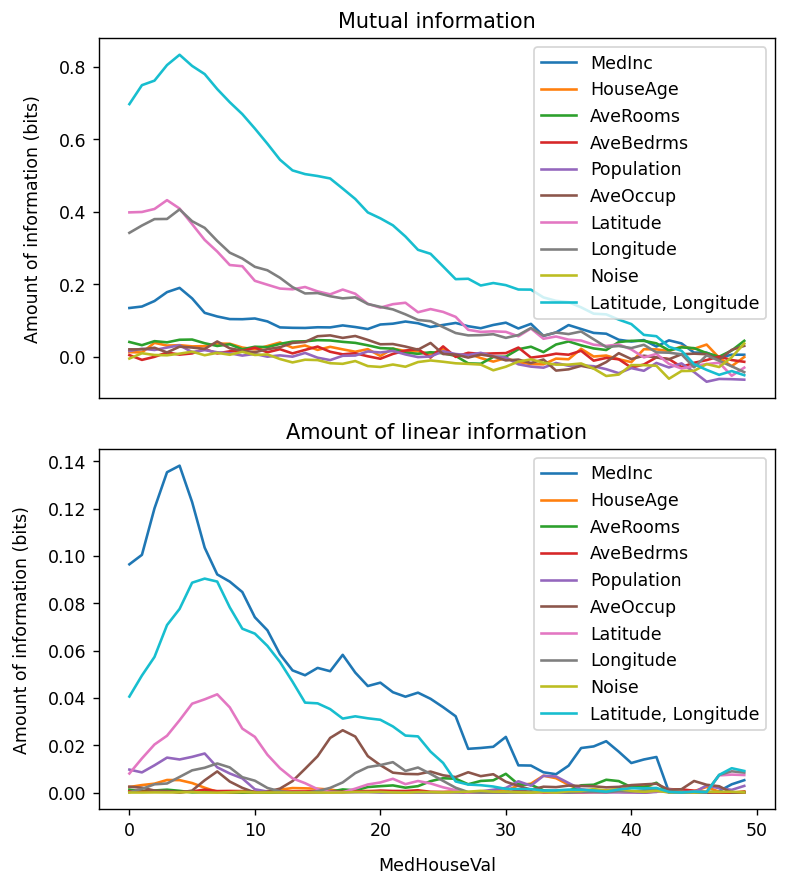

In [31]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6.4, 1.5*4.8), dpi=125)

# vmax = 0
for var in handler.variable_names + [["Latitude", "Longitude"]]:

    d = handler.read(
        handler.target_names[0], var, handler.target_names[0]
    )

    xticks = d["mi"]["coords"][0]
    prof_mi = d["mi"]["data"]
    prof_lin = d["linearinfo"]["data"]

    # vmax = max(vmax, np.nanmax(prof_mi), np.nanmax(prof_lin))

    label = var if isinstance(var, str) else f"{', '.join(var)}"

    ax1.plot(prof_mi, label=label)
    ax2.plot(prof_lin, label=label)

# ax1.set_ylim([-0.05 * vmax, 1.1 * vmax])
# ax2.set_ylim([-0.05 * vmax, 1.1 * vmax])

ax1.set_xticks([])

ax2.set_xlabel(handler.target_names[0], labelpad=10)
ax1.set_ylabel("Amount of information (bits)", labelpad=10)
ax2.set_ylabel("Amount of information (bits)", labelpad=10)

ax1.set_title("Mutual information")
ax2.set_title("Amount of linear information")

ax1.legend()
ax2.legend()

plt.tight_layout()
plt.show()